# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.101864,True,5.706689
1,-1.180751,False,-1.442574
2,1.142004,True,4.478894
3,-0.940704,False,1.193336
4,-0.353198,False,-1.009174
...,...,...,...
995,-1.034259,False,-0.770315
996,0.840900,True,4.824461
997,0.820823,True,5.220251
998,0.179569,True,5.798508


<AxesSubplot: xlabel='v0'>

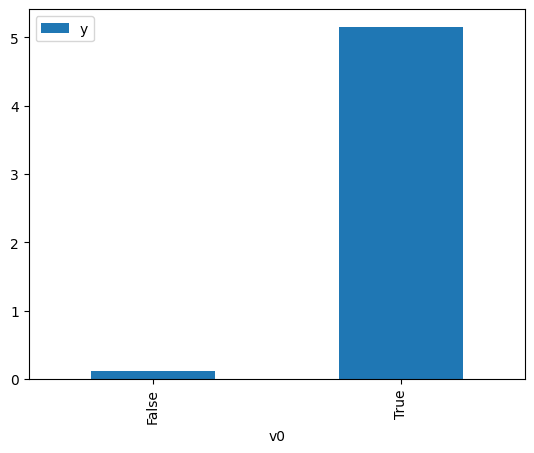

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

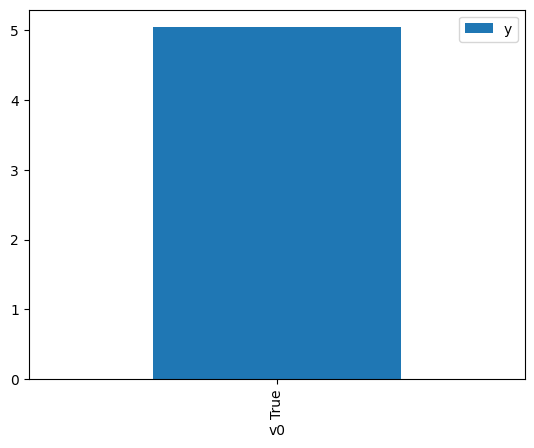

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.035746,False,0.981922,0.055712,17.949374
1,1.130488,False,0.243994,0.044105,22.673017
2,-1.177293,False,-1.788099,0.948444,1.054359
3,-0.774397,False,-1.723342,0.866078,1.154630
4,0.065529,False,0.867803,0.422452,2.367135
...,...,...,...,...,...
995,-0.488466,False,-0.756769,0.754876,1.324722
996,-2.289265,False,0.885360,0.996974,1.003035
997,0.678382,False,-1.229648,0.129776,7.705612
998,0.863893,False,-0.410749,0.084377,11.851556


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.755251,True,5.676761,0.891137,1.122162
1,-0.259723,True,4.749858,0.370226,2.701051
2,0.276677,True,5.039667,0.702787,1.422907
3,0.375314,True,5.474718,0.753347,1.327409
4,1.016223,True,6.633243,0.941562,1.062065
...,...,...,...,...,...
995,1.716627,True,4.924540,0.990018,1.010082
996,-1.073979,True,3.615461,0.066355,15.070415
997,0.748306,True,5.375911,0.889376,1.124384
998,0.685417,True,4.453182,0.872272,1.146431


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                              7064.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        18:24:13   Log-Likelihood:                         -1401.6
No. Observations:                1000   AIC:                                      2807.
Df Residuals:                     998   BIC:                                      2817.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2130      0.036      5.939      0.000       0.143       0.283
x2             4.9560      0.049    101.842      0.000       4.860       5.051
==============================================================================
Omnibus:                        8.468   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.659
Skew:                          -0.102   Prob(JB):                      0.00485
Kurtosis:                       3.462   Cond. No.                         1.83
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""